Стан Илья 520, итоговое задание

In [1]:
# %pip install hmmlearn prophet keras tensorflow bsts

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from hmmlearn import hmm
from keras.models import Sequential
from keras.layers import LSTM, Dense
import bsts
import warnings
warnings.filterwarnings('ignore')

/Users/ilia.stan/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Даны 3 временных ряда.

Для них применить следующие алгоритмы:

1) Для каждого ряда:
- HMM
- Prophet
- Bayes
- LSTM
- SARIMA
- Garch

Для двух коинтегрированных рядов:
- Лучший из прошлых (получаем прогноз для каждого ряда по отдельности, затем объединяем)
- VAR
- LSTM

Все алгоритмы сравнить.

# Изучим данные

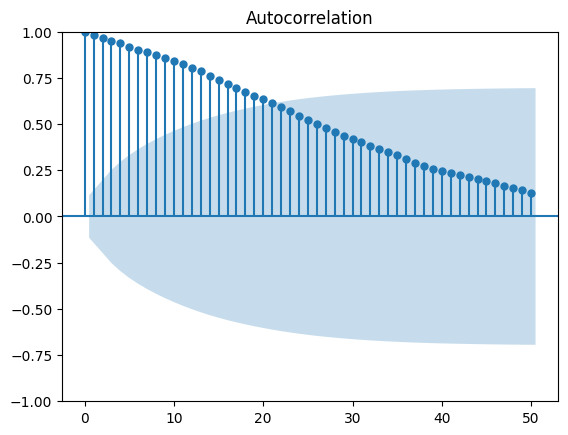

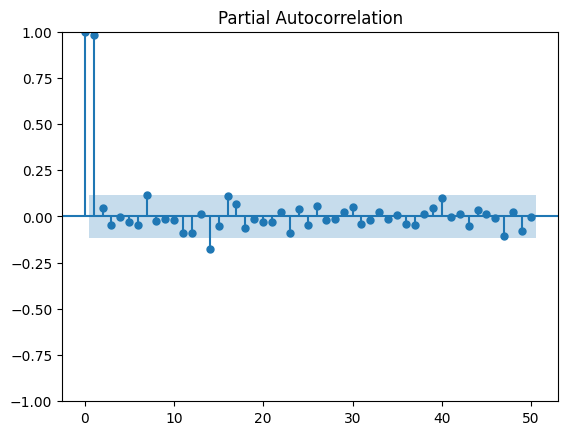

In [3]:
df = pd.read_csv("Ondo.csv", sep=";")
data = df["close"].to_numpy(float)

# Train-test split
train_size = int(0.8 * len(data))
train, test = data[:train_size], data[train_size:]

plot_acf(train, lags=50)
plt.show()
plot_pacf(train, lags=50)
plt.show()

AR(1) хорошо подойдёт. (Но нужно одно дифференцирование (из прошлых дз)).

# Построим модели и получим метрики

In [4]:
def evaluate(actual, forecast, model_name):
    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    return {'Model': model_name, 'MAE': mae, 'RMSE': rmse}

def plot_results(data, forecasts, model_names):
    plt.figure(figsize=(12, 6))
    for i, forecast in enumerate(forecasts):
        plt.plot(np.arange(len(data)-len(forecast), len(data)), forecast, label=model_names[i])
        plt.plot(data, label="data")
        plt.legend()
        plt.show()


In [5]:
results = []
forecasts = []
model_names = []

# Naive Forecast
naive_forecast = np.repeat(train[-1], len(test))
results.append(evaluate(test, naive_forecast, 'Naive'))
forecasts.append(naive_forecast)
model_names.append('Naive')

# Exponential Smoothing
ets_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=28)
ets_fit = ets_model.fit()
ets_forecast = ets_fit.forecast(len(test))
results.append(evaluate(test, ets_forecast, 'ETS'))
forecasts.append(ets_forecast)
model_names.append('ETS')

# SARIMA
sarima_model = ARIMA(train, order=(0,0,2), seasonal_order=(0,0,1,28))
sarima_fit = sarima_model.fit()
sarima_forecast = sarima_fit.forecast(len(test))
results.append(evaluate(test, sarima_forecast, 'SARIMA'))
forecasts.append(sarima_forecast)
model_names.append('SARIMA')

# Prophet
prophet_df = pd.DataFrame({'ds': pd.date_range(start='2024-04-28', periods=len(train), freq='D'), 'y': train})
prophet_model = Prophet("linear", n_changepoints=2)
prophet_model.fit(prophet_df)
future = prophet_model.make_future_dataframe(periods=len(test), freq='D')
prophet_forecast = prophet_model.predict(future)['yhat'][-len(test):].values
results.append(evaluate(test, prophet_forecast, 'Prophet'))
forecasts.append(prophet_forecast)
model_names.append('Prophet')

# LSTM
def create_dataset(data, n_steps=3):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps)])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

n_steps = 10
X_train, y_train = create_dataset(train, n_steps)
X_test, y_test = create_dataset(test, n_steps)

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
lstm_model.fit(X_train, y_train, epochs=10, verbose=0)

lstm_forecast = []
last_batch = train[-n_steps:].reshape((1, n_steps, 1))
for i in range(len(test)):
    pred = lstm_model.predict(last_batch, verbose=0)
    lstm_forecast.append(pred[0,0])
    last_batch = np.append(last_batch[:,1:,:], pred.reshape(1,1,1), axis=1)

results.append(evaluate(test, lstm_forecast, 'LSTM'))
forecasts.append(lstm_forecast)
model_names.append('LSTM')

# Hidden Markov Model
hmm_model = hmm.GaussianHMM(n_components=5, covariance_type="full", n_iter=1000)
hmm_model.fit(train.reshape(-1, 1))

state_sequence = hmm_model.predict(train.reshape(-1, 1))
last_state = state_sequence[-1]

hmm_forecast = []
current_state = last_state

for _ in range(len(test)):
    state_mean = hmm_model.means_[current_state][0]
    state_var = hmm_model.covars_[current_state][0]
    predicted_value = np.random.normal(state_mean, np.sqrt(state_var))
    hmm_forecast.append(predicted_value)
    current_state = np.argmax(hmm_model.transmat_[current_state])

results.append(evaluate(test, hmm_forecast, 'HMM'))
forecasts.append(hmm_forecast)
model_names.append('HMM')

# Bayesian Structural Time Series
model = bsts.BSTS(seasonality=7)
model.fit(y_train, num_warmup=100, num_samples=200, num_chains=2)
bsts_forecast = np.mean(model.predict(len(test)), axis=0)

results.append(evaluate(test, bsts_forecast, 'Bayesian'))
forecasts.append(bsts_forecast)
model_names.append('Bayesian')

13:05:46 - cmdstanpy - INFO - Chain [1] start processing
13:05:46 - cmdstanpy - INFO - Chain [1] done processing
sample: 100%|██████████| 300/300 [00:40<00:00,  7.38it/s, 1023 steps of size 1.50e-03. acc. prob=0.43]



Model Performance Comparison:
      Model       MAE      RMSE
1       ETS  0.179461  0.204076
2    SARIMA  0.184783  0.207343
5       HMM  0.187411  0.209830
0     Naive  0.195387  0.219265
6  Bayesian  0.195019  0.245415
4      LSTM  0.208360  0.261499
3   Prophet  0.255954  0.355708


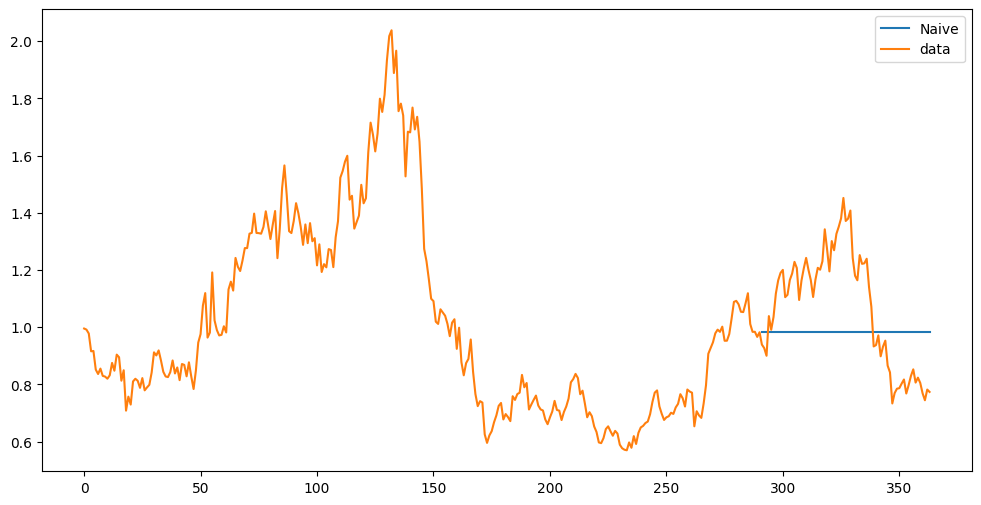

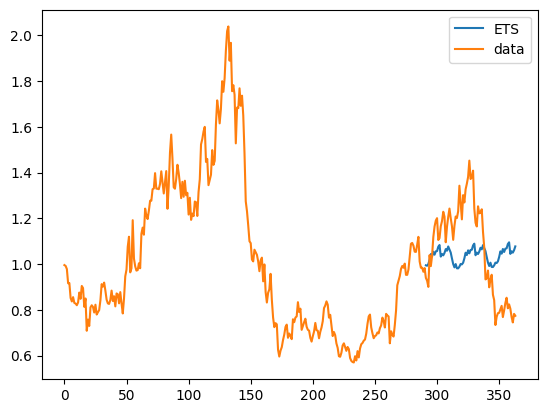

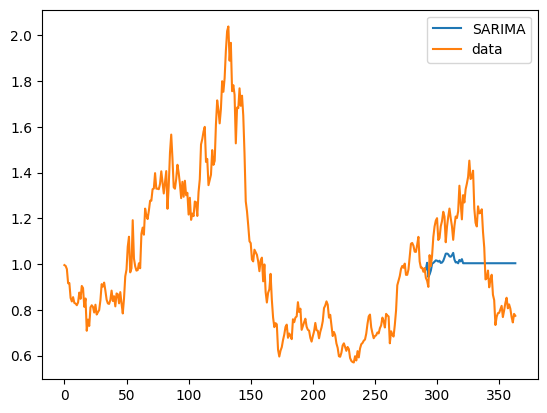

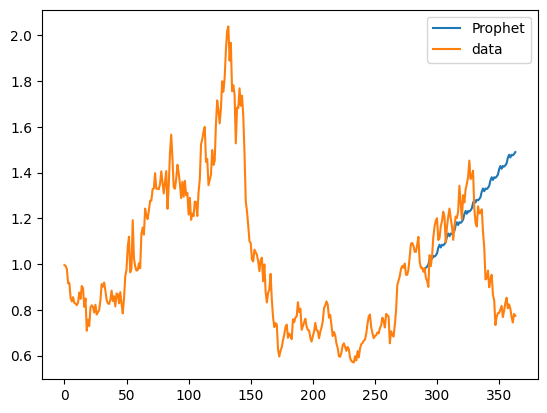

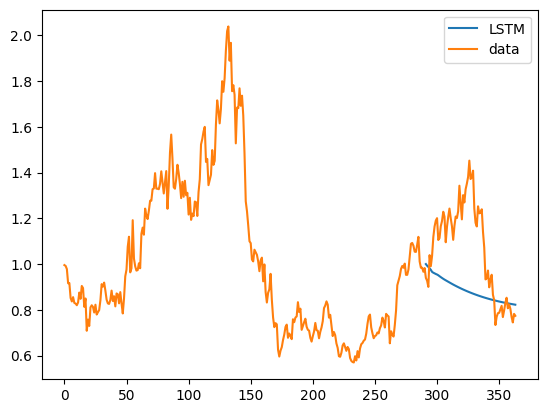

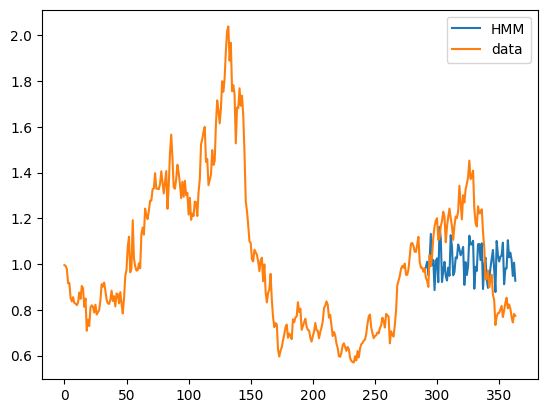

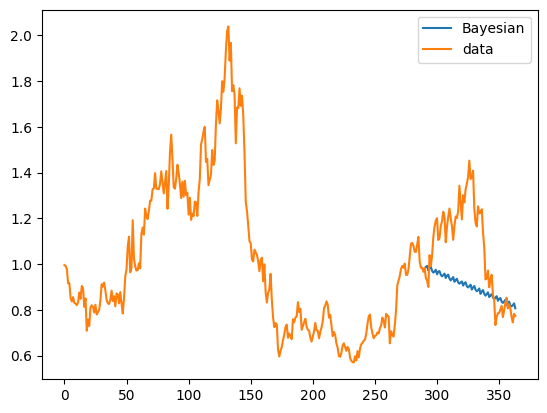

In [6]:
# Results Comparison
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(results_df.sort_values('RMSE'))

# Plot forecasts
plot_results(data, forecasts, model_names)

Как будто бы LSTM уловил какие-то особенности.

Вторым по качеству я бы поставил Prophet (уловил положительный тренд).

Третьим хорошо справился ETS (прогноз на небольшое число лагов).

Остальные я бы сказал, что не справились.

Bayesian по сравнению с другими моделями обучается вечность, что (для меня), откидывает его вниз списка. Кроме того, качество модели очень сильно зависит от num_* параметров и от порядка сезонности (то есть помимо долгого обучения нужен ещё и гридсёрч, что вообще мощно).

Так же отмечу, что рейтинг по метрикам моделей не даёт возможности выбрать лучшую модель (на втором месте в топе Naive на 70 дней вперёд - забавно).

Так же отмечу, что прогнозирование Arch моделями - то же, что ARIMA, но с "прокачанными" доверительными интервалами. В контексте сравнения моделей нужен прогноз, так что ограничились лишь SARIMA.

И, наконец, скажем, что временной ряд получился весьма непростым, поэтому на линейные модели надежда слабая.

# Сравнение векторных моделей

1) VAR

2) VECM

3) LSTM

In [7]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR, VECM
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import warnings
warnings.filterwarnings('ignore')

In [8]:
def evaluate(actual, forecast, model_name):
    mae = mean_absolute_error(actual, forecast)
    mse = mean_squared_error(actual, forecast)
    rmse = np.sqrt(mse)
    return {
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    }


def check_same_dates(*dfs):
    for i in range(len(dfs)):
        dfs[i][0][dfs[i][1]] = pd.to_datetime(dfs[i][0][dfs[i][1]], format='mixed')
        dfs[i][0].set_index(dfs[i][1], inplace=True, drop=True)

    for i in range(len(dfs)-1):
        for j in range(i+1, len(dfs)):
            d1, d2 = set(dfs[i][0].index.tolist()), set(dfs[j][0].index.tolist())
            print(i, j, d1.symmetric_difference(d2) == set(), d1.symmetric_difference(d2))
            dfs[i][0].drop(d1-d2, inplace=True)
            dfs[j][0].drop(d2-d1, inplace=True)
            d1, d2 = set(dfs[i][0].index.tolist()), set(dfs[j][0].index.tolist())
            print(i, j, d1.symmetric_difference(d2) == set(), d1.symmetric_difference(d2))
    
    res = pd.DataFrame()
    res.index = dfs[0][0].index
    for e in dfs:
        res[e[2]] = e[0][e[3]]
    return res


def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df, det_order=1, k_ar_diff=0)
    d = {'0.9':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--' * 20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)
    print(' '+'==' * 20)

In [9]:
rbcm = pd.read_csv("Soft_RBCM.csv").iloc[::-1]
svet = pd.read_csv("Soft_SVET.csv").iloc[::-1]

soft = check_same_dates([rbcm, "Дата", "RBCM", "Откр."], [svet, "Дата", "SVET", "Откр."])
for i in soft.columns:
    soft[i] = soft[i].apply(lambda x: x.replace(".", "").replace(",", ".")).astype(float)

train_size = int(0.8 * len(soft))

data = soft.values
train, test = data[:train_size], data[train_size:]

cointegration_test(soft.iloc[:train_size])

0 1 True set()
0 1 True set()
Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
RBCM   ::  36.46     > 18.3985   =>   True
SVET   ::  8.21      > 3.8415    =>   True



Model Performance Comparison:
  Model       MAE        MSE      RMSE
0   VAR  2.040377   7.180272  2.679603
1  VECM  2.323397   8.099054  2.845884
2  LSTM  2.532477  10.454673  3.233369


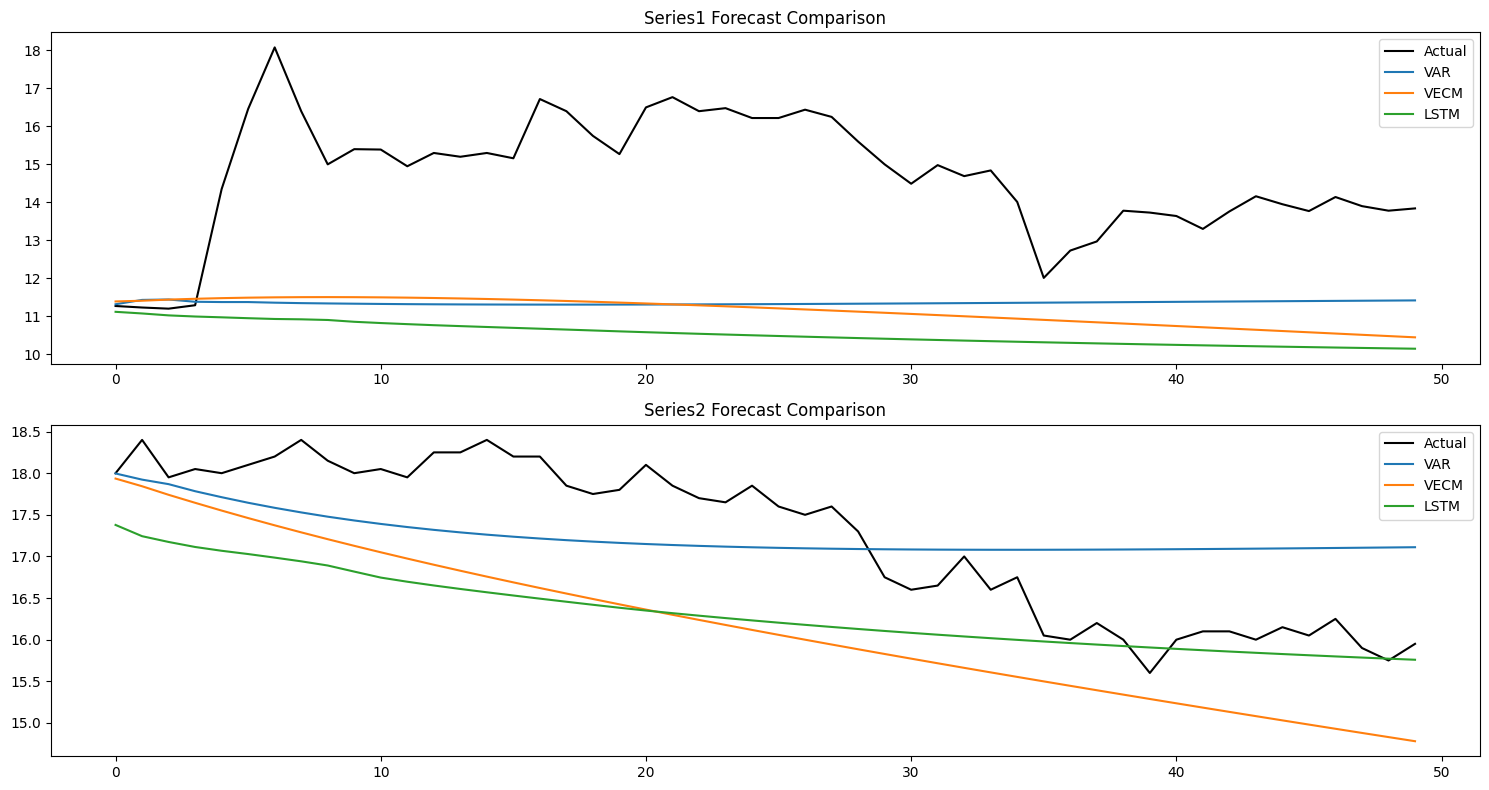

In [34]:
results = []

# Vector Autoregression (VAR)
df_train = pd.DataFrame(train, columns=['Series1', 'Series2'])
var_model = VAR(df_train)
var_result = var_model.fit(maxlags=8, ic='aic')

lag_order = var_result.k_ar
var_forecast = var_result.forecast(train[-lag_order:], steps=len(test))
results.append(evaluate(test, var_forecast, 'VAR'))

# Vector Error Correction Model (VECM)
vecm_model = VECM(train, k_ar_diff=1, coint_rank=2)
vecm_result = vecm_model.fit()

vecm_forecast = vecm_result.predict(steps=len(test))
results.append(evaluate(test, vecm_forecast, 'VECM'))

# LSTM Multivariate
def run_lstm(train, n_steps=10):

    def create_dataset(X, n_steps):
        Xs, ys = [], []
        for i in range(len(X) - n_steps):
            Xs.append(X[i:(i + n_steps)])
            ys.append(X[i + n_steps])
        return np.array(Xs), np.array(ys)

    X_train, y_train = create_dataset(train, n_steps)

    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(n_steps, 2)))
    model.add(Dense(2))
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train, epochs=20, verbose=0)

    lstm_forecast = []
    current_batch = train[-n_steps:].reshape(1, n_steps, 2)

    for _ in range(len(test)):
        next_pred = model.predict(current_batch, verbose=0)
        lstm_forecast.append(next_pred[0])
        current_batch = np.append(current_batch[:, 1:, :], [[next_pred[0]]], axis=1)

    lstm_forecast = np.array(lstm_forecast)

    return lstm_forecast

lstm_forecast = run_lstm(train)
results.append(evaluate(test, lstm_forecast, 'LSTM'))

# Results Comparison
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(results_df.sort_values('RMSE'))

# Visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))

for i, col in enumerate(['Series1', 'Series2']):
    plt.subplot(2, 1, i+1)
    plt.plot(test[:, i], label='Actual', color='black')
    plt.plot(var_forecast[:, i], label='VAR')
    plt.plot(vecm_forecast[:, i], label='VECM')
    plt.plot(lstm_forecast[:, i], label='LSTM')
    plt.title(f'{col} Forecast Comparison')
    plt.legend()

plt.tight_layout()
plt.show()

Я бы сказал, что все модели примерно одинаковы, однако LSTM строит примерно одинаковый (с точки зрения производной графика прогноза) прогноз для всех связанных рядов (Хотя поведение связанных рядов, в общем случае, может быть не совсем одинаковым).

LSTM лучше всех на втором ряде

VAR лучше других на первом ряде

VECM, наверное хуже всех (но тоже очень хорошо).

Вердикт - Выбирать модель не только по ошибкам, но и по тесту.

Интересное наблюдение: Чем больше эпох в LSTM, тем ближе она к VAR.

В перспективе можно проверять на большем числе коинтегрированных рядов.